In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
import os
os.environ["STREAMLIT_SERVER_HEADLESS"] = "true"
# os.environ["STREAMLIT_SERVER_HEADLESS"] = "true"
os.environ["STREAMLIT_CACHE_TYPE"] = "memory"

from astropy.io import fits
%matplotlib inline
from matplotlib import pyplot as plt
from astropy.wcs import WCS
import numpy as np
from sutra.plots import compute_skeleton_image
from astropy.wcs import WCS
from sutra.plots import make_wcs_good
from astrools.image import Image


In [ ]:
from sutra.tracer.predictor import filamentIdentifier as FID
from sutra.measurement import local_field as LF

In [6]:
plt.rcParams.update({'font.size':12})
plt.style.use('classic')
plt.rcParams.update({
    'figure.facecolor': '1',
    'figure.dpi' : 120,
    'font.size':12,
    'font.family' : 'monospace', 
    'axes.titlelocation': 'left',
    'axes.titleweight': 'bold',
    'axes.titley': 1.02,
})

In [4]:
plt.rcParams.update({'font.size':12})

# Props on Mon-R2

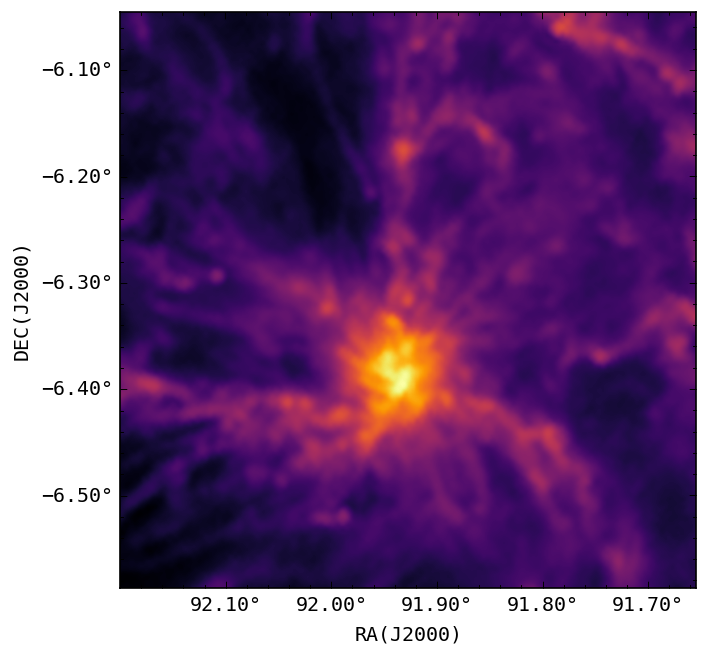

In [7]:
monr2 = fits.open('/home/kumaran/Documents/SPACE_SCIENCE/THz/THZ-data/monR2/monr2_coldens_cf_r500_medsmo3.fits')[0]
loc = 91.9271575 , -6.3162905
monr2_crop = Image(monr2).get_crop(loc = loc , size = 650)
monr2_crop.writeto('../temp/monr2-cd-crop.fits', overwrite=True)
Image(monr2_crop[0]).plot_image(cmap='inferno')

In [8]:
monr2_crop = fits.open('../temp/monr2-cd-crop.fits')

In [ ]:
prob_map = FID('HiGAL').predict(monr2_crop[0], window_overlap_frac = 0.95, batch_size = None, n_jobs = 1)
np.save('../temp/monr2-crop-prob-map-higal.np', prob_map)

In [11]:
monr2_prob_map = np.load('../temp/monr2-crop-prob-map-higal.np.npy')

# np.savetxt('temp/aquila-prob-map.np', prob_map)
meta_info = {
                'distance' : 830, # 140 pc for Taurus , 260 for musca
                'beam' : 36.4 , # arcsec 
                'radial-cutoff' : 0.6 , 
            } 

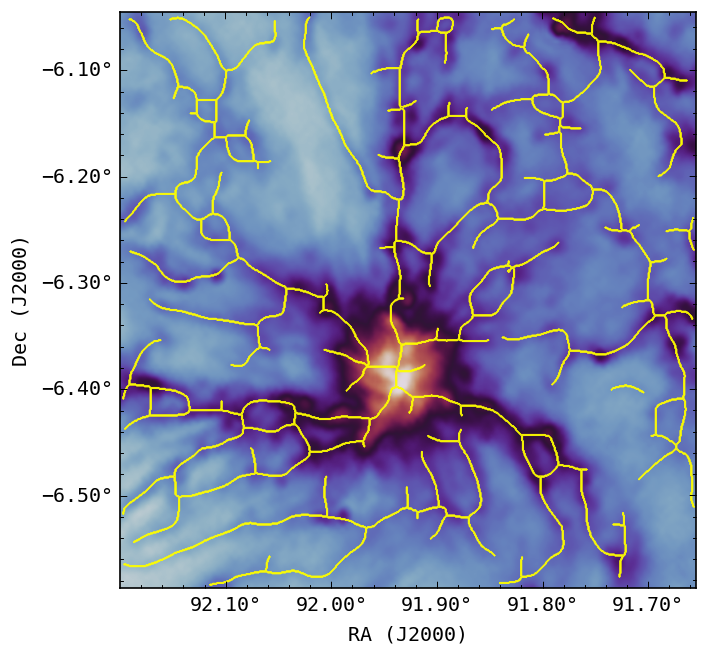

In [13]:
from sutra.profilerV2.prob2skl import run_skel
th_max = 0.45
beam_size = 12
skel = run_skel(prob_map, th_max = th_max, bkg_mask=None, beam_size=12, prune = True, convolve_map=True)

ax = plt.subplot(111, projection = WCS(monr2_crop[0].header))
ax.imshow(monr2_crop[0].data , cmap = 'twilight', norm = 'log', vmin = 1e21, vmax = 1e23)
ax.contour(skel, colors = 'yellow', linewidths = 0.2, alpha = 1)
ax = make_wcs_good(ax)
plt.show()

In [ ]:
from sutra.profilerV2.radprof import RadProf
# N_CUT_OFF = 60
!streamlit cache clear
monr2aprof = RadProf(monr2_crop[0], skel, meta_info=meta_info)
monr2aprof.tangents(ks = 3, stride=2)
monr2aprof.reorder()
monr2aprof.spline_smooth()
monr2aprof.cut_off_points(alpha_pc=1.5)
monr2aprof.create_rad_profile_single_thread()
# aquilaprof.group_profiles(stride = 2)

In [ ]:
monr2aprof.group_profiles()
monr2aprof.get_all_beam_props()

In [16]:
monr2aprof.beamProps['Wbg'] = (monr2aprof.beamProps['Rbg_l']+monr2aprof.beamProps['Rbg_r'])

574


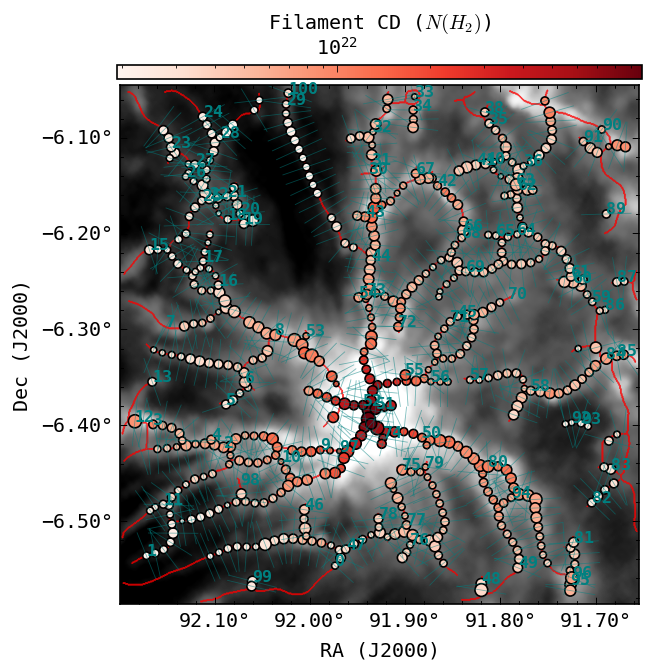

In [17]:
plt.rcParams.update({'font.size':12})
ax, sc = monr2aprof.plot_props(sizescale=0.5, sizeby='Wbg', show_filid=True, red_chi_filter=5, colorby='Nfil')
fig = plt.gcf()
cbar = ax.figure.colorbar(sc,
                              ax=ax,
                              orientation='horizontal',
                              location='top',
                              pad=0.01,        # distance from the axis
                              shrink=0.65, 
                              aspect = 40,
                              )    # make it a little narrower
cbar.set_label('Filament CD ($N(H_2)$)')               # optional label
plt.show()

/home/kumaran/Documents/SPACE_SCIENCE/python-scripts/sutra/sutra/profilerV2/radprof.py:509: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fprops.loc[:,'flag'] = (fprops['FC'] > contrast_filter) & (fprops['red-chi-avg']<red_chi_filter)


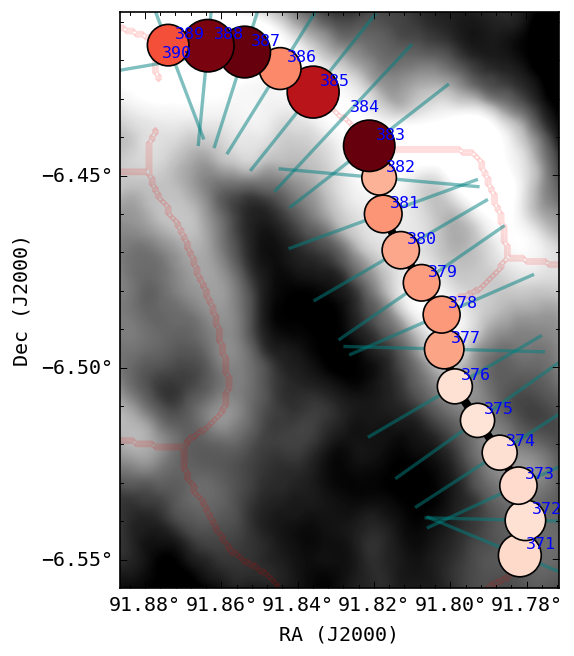

In [24]:
monr2aprof.plot_filament(49, sizescale=10, red_chi_filter=5, sizeby='Wbg', show_beamid=True)
plt.show()

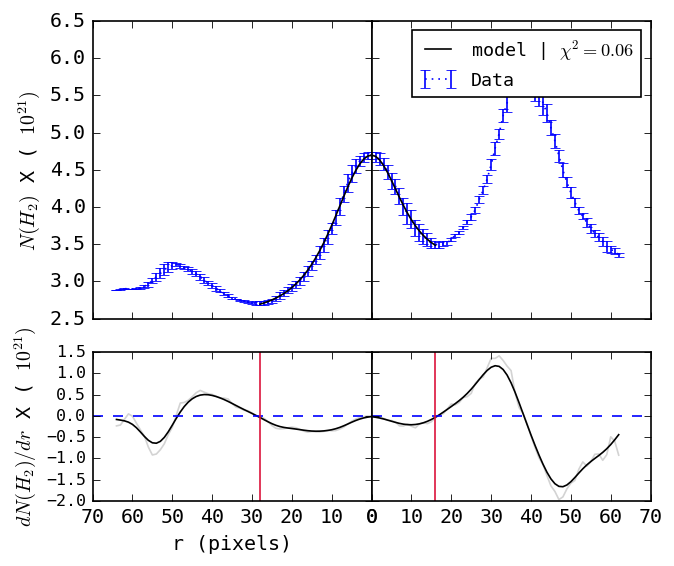

In [28]:
monr2aprof.beam_dict['beam_elements'][374].plot_plummer()